### Imports

In [1]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback

import torch

### Create Env

In [2]:
env_name = 'stocks-v0'  # or 'forex-v0'
env = gym.make(env_name)

### Define Functions

In [3]:
def print_stats(metric_values, metric_name="Reward"):
    """Print basic stats for the provided metric."""
    metric_values = np.array(metric_values, dtype=float)

    avg = np.mean(metric_values)
    min_val = np.min(metric_values)
    max_val = np.max(metric_values)

    print(f'Min. {metric_name:<12}: {min_val:>10.3f}')
    print(f'Avg. {metric_name:<12}: {avg:>10.3f}')
    print(f'Max. {metric_name:<12}: {max_val:>10.3f}')

    return min_val, avg, max_val


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """Train (if model provided) and evaluate over episodes, tracking reward and profit."""

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []
    profit_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        done = False
        final_profit = None
        last_info = None

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)

                step_reward = reward[0] if isinstance(reward, (np.ndarray, list, tuple)) else reward
                total_reward += step_reward

                info_dict = info[0] if isinstance(info, (list, tuple)) else info
                last_info = info_dict
                final_profit = info_dict.get('total_profit', final_profit)

                done_flag = done[0] if isinstance(done, (np.ndarray, list, tuple)) else done
                done = bool(done_flag)
            else:  # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

                total_reward += reward
                last_info = info
                final_profit = info.get('total_profit', final_profit)

            if done:
                break

        reward_over_episodes.append(total_reward)
        profit_over_episodes.append(final_profit if final_profit is not None else (last_info.get('total_profit') if last_info else np.nan))

        if episode % 10 == 0:
            avg_profit = np.nanmean(profit_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Profit: {avg_profit:.3f}')
            tbar.update()

    tbar.close()

    return reward_over_episodes, profit_over_episodes

### Train + Test Env

In [4]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards, profits = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min_p, avg_p, max_p = print_stats(profits, metric_name="Profit")
class_name = f'Random actions'
label = f'Avg. {avg_p:>7.4f} : {class_name}'
plot_data['rnd_profit'] = profits
plot_settings['rnd_profit'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_profit_'+step_key
            rewards, profits = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
            min_p, avg_p, max_p = print_stats(profits, metric_name="Profit")
            label = f'Avg. {avg_p:>7.4f} : {class_name} - {step_key}'
            plot_data[plot_key] = profits
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : stocks-v0
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Profit: 0.000: 100%|██████████| 50/50 [00:00<00:00, 56.06it/s]


Min. Profit      :      0.000
Avg. Profit      :      0.000
Max. Profit      :      0.000
--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Profit: 0.000: 100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


Min. Profit      :      0.000
Avg. Profit      :      0.000
Max. Profit      :      0.001
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:16, 1643.66it/s]                           
Episode: 40, Avg. Profit: 0.001: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]

Min. Profit      :      0.000
Avg. Profit      :      0.001
Max. Profit      :      0.002


### Plot Results

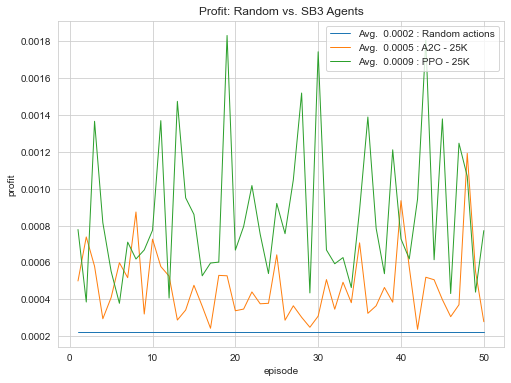

In [5]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('profit')
plt.title('Profit: Random vs. SB3 Agents')
plt.legend()
plt.show()